Neural Machine Translation 
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder 

In [1]:
# Add utilities path
import sys
import os
path = os.getcwd() + '/pyfiles'
sys.path.append(path)

In [2]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

In [3]:
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
import time
from tqdm import notebook
from functools import partial
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
torch.manual_seed(2022)
torch.cuda.manual_seed(2022)
np.random.seed(2022)

In [6]:
# Load data
import os

source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [7]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [8]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [9]:
dataset_dict['train'].main_df.iloc[:5]

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
0,i think we may have something that you d be in...,je pense que nous avons peut etre quelque chos...,"[i, think, we, may, have, something, that, you...",15,"[je, pense, que, nous, avons, peut, etre, quel...",19,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,they got it .,ils l ont eue .,"[they, got, it, .]",5,"[ils, l, ont, eue, .]",6,"[18, 19, 20, 17, 3]","[22, 19, 23, 24, 21, 3]"
2,i m glad to see you .,je suis enchante de vous rencontrer .,"[i, m, glad, to, see, you, .]",8,"[je, suis, enchante, de, vous, rencontrer, .]",8,"[4, 21, 22, 23, 24, 11, 17, 3]","[4, 25, 26, 17, 14, 27, 21, 3]"
3,he got into his car in a hurry .,il monta en vitesse dans sa voiture .,"[he, got, into, his, car, in, a, hurry, .]",10,"[il, monta, en, vitesse, dans, sa, voiture, .]",9,"[25, 19, 26, 27, 28, 15, 29, 30, 17, 3]","[28, 29, 30, 31, 32, 33, 34, 21, 3]"
4,do you like mozart s music ?,aimez vous la musique de mozart ?,"[do, you, like, mozart, s, music, ?]",8,"[aimez, vous, la, musique, de, mozart, ?]",8,"[31, 11, 32, 33, 34, 35, 36, 3]","[35, 14, 36, 37, 17, 38, 39, 3]"


In [10]:
from functools import partial
from torch.utils.data import DataLoader

dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [11]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
# hidden_size = 512
# enc_layers = 1
# lr = 0.25
# longest_label = 1
# gradient_clip = 0.3
# num_epochs = 20

use_cuda = True

#### 1.1 Encoder 

### reference
https://torchtutorialstaging.z5.web.core.windows.net/beginner/translation_transformer.html


In [12]:
'''
http://nlp.seas.harvard.edu/annotated-transformer/
'''
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [13]:
# Add transformer as encoder in seq2seq model

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
    def __init__(self, options):
        super(EncoderTransformer, self).__init__()
        # you need to add more things here
        self.embed = nn.Embedding(num_embeddings=options['vocab_size'], embedding_dim=options['embedding_dim'])
        # sinusoidal embedding
        self.position_embed = PositionalEncoding(options['d_model'], options['dropout'])
        encoder_layer = nn.TransformerEncoderLayer(d_model=options['d_model'], nhead=options['nhead'], batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=options['num_layers'])

    def forward(self, text_vec):
        # some helpful directions below, check the MLM lab for more details
        
        # embedded = pos_embedded + embedded  # apply pos embedding
        # output = self.transformer(embedded)

        embedded = self.embed(text_vec)
        pos_embedded = self.position_embed(embedded)
        embedded = pos_embedded + embedded
        output = self.transformer(embedded)
        hidden = torch.sum(output, dim=1).unsqueeze(0)

        return output, hidden

#### 1.2 Decoder(s) 

In [14]:
# Hyperparameters
hidden_size = 512
enc_layers = num_layers = 1
lr = 0.01
longest_label = 1
gradient_clip = 0.3
use_cuda = True

num_epochs = 20

options = {
    'hidden_size': hidden_size,
    'd_model': hidden_size,
    'embedding_dim': hidden_size,
    'max_len': MAX_LEN,
    'dropout': 0.0,
    'nhead': 2,
    'num_layers': num_layers,
    'vocab_size': source_vocab,
}
options

{'hidden_size': 512,
 'd_model': 512,
 'embedding_dim': 512,
 'max_len': 32,
 'dropout': 0.0,
 'nhead': 2,
 'num_layers': 1,
 'vocab_size': 12392}

In [15]:
encoder_trans = EncoderTransformer(options)

In [16]:
# Basic RNN decoder (no attention)
decoder_rnn = nnet_models_new.DecoderRNN(output_size=target_vocab, 
                                    hidden_size=hidden_size, 
                                    numlayers=num_layers)

arch_1 = nnet_models_new.seq2seq(encoder_trans, decoder_rnn,
                                 lr=lr, 
                                 use_cuda=use_cuda, 
                                 hiddensize=hidden_size, 
                                 numlayers=hidden_size, 
                                 target_lang=dataset_dict['train'].target_lang_obj,
                                 longest_label=longest_label,
                                 clip=gradient_clip)

In [17]:
# RNN Decoder with Encoder attention
encoder_attention = True
self_attention = False

decoder_att = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                          hidden_size=hidden_size, 
                                          encoder_attention=encoder_attention,
                                          self_attention=self_attention)

arch_2 = nnet_models_new.seq2seq(encoder_trans, decoder_att,
                                 lr=lr, 
                                 use_cuda=use_cuda, 
                                 hiddensize=hidden_size, 
                                 numlayers=hidden_size, 
                                 target_lang=dataset_dict['train'].target_lang_obj,
                                 longest_label=longest_label,
                                 clip=gradient_clip)

In [18]:
# RNN Decoder with Encoder & Self attention
encoder_attention = True
self_attention = True

decoder_self_att = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                          hidden_size=hidden_size, 
                                          encoder_attention=encoder_attention,
                                          self_attention=self_attention)

arch_3 = nnet_models_new.seq2seq(encoder_trans, decoder_self_att,
                                 lr=lr, 
                                 use_cuda=use_cuda, 
                                 hiddensize=hidden_size, 
                                 numlayers=hidden_size, 
                                 target_lang=dataset_dict['train'].target_lang_obj,
                                 longest_label=longest_label,
                                 clip=gradient_clip)

#### Training & Evaluation

In [19]:
def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [20]:
def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))

In [21]:
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):
    losses = []
    bleus = []
    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        losses.append(epoch_loss)
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            bleus.append(val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                save_models(nmt, saved_model_path, enc_type);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    
    return losses, bleus

In [22]:
# Train

### Training Different Architectures

#### Basic RNN decoder (no attention)

In [23]:
loss_arch_1, score_arch_1 = train_model(dataloader_dict, 
                                        arch_1, 
                                        num_epochs=num_epochs, 
                                        saved_model_path=saved_models_dir, 
                                        enc_type='decoder_rnn')

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.0228658362108582, time = 185.666836977005
validation bleu:  11.370902412317212
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.3473271173453396, time = 180.28827476501465
validation bleu:  15.920776408322686
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.1299852794227176, time = 180.12464499473572
validation bleu:  18.91845527656797
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 0.998170419280879, time = 177.79382395744324
validation bleu:  20.9251042559909
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 0.8995250914235524, time = 177.63957905769348
validation bleu:  22.36320506128838
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 0.8234964919717689, time = 177.75940799713135
validation bleu:  23.670351941205695
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 0.7562291311260075, time = 177.31111907958984
validation bleu:  25.33553375221378
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 0.7066579944209048, time = 176.9720344543457
validation bleu:  25.63724965667036
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 0.6610804107215597, time = 176.32625555992126
validation bleu:  26.778640678443512
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 0.6243890383732286, time = 176.32930040359497
validation bleu:  27.43228673935885
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.5897311148055703, time = 177.02459812164307
validation bleu:  28.18234493329539
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.5581421512976248, time = 177.72151827812195
validation bleu:  28.68938341623638
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.5298261768930176, time = 175.7361719608307
validation bleu:  28.956493761477468
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.5077946471870771, time = 176.79750299453735
validation bleu:  29.486631763606738
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.48269202341003103, time = 178.56542110443115
validation bleu:  30.01223913058256
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.4614750240565667, time = 177.87414264678955
validation bleu:  30.157593752245248
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.4438194066451197, time = 177.70311641693115
validation bleu:  30.488126580836298
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.42689480353920745, time = 177.83714318275452
validation bleu:  30.838963298504208
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.40927395987378595, time = 177.67556381225586
validation bleu:  30.995747195966523
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.39631416280018655, time = 177.60513973236084
validation bleu:  31.216894231899865
Training completed. Best BLEU is 31.216894231899865


In [24]:
torch.save({
    'loss_cache': loss_arch_1,
    'bleu_cache': score_arch_1,
    'model': arch_1
    }, 'arch_1')

In [25]:
loss_arch_1 = torch.load('arch_1', map_location=global_variables.device)['loss_cache']
score_arch_1 = torch.load('arch_1',map_location=global_variables.device)['bleu_cache']

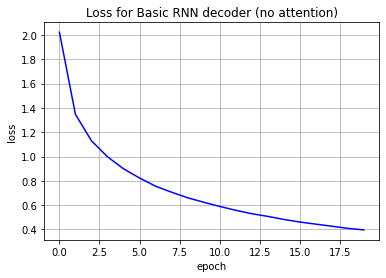

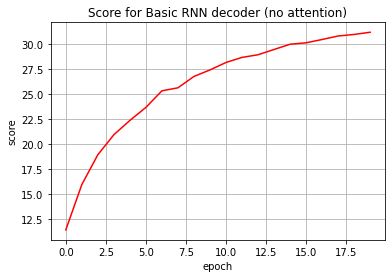

In [26]:
plt.plot(loss_arch_1, color='b')
plt.title('Loss for Basic RNN decoder (no attention)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.plot(score_arch_1,color='r')
plt.title('Score for Basic RNN decoder (no attention)')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid()
plt.show()

#### RNN Decoder with Encoder attention

In [22]:
loss_arch_2, score_arch_2 = train_model(dataloader_dict, 
                                        arch_2, 
                                        num_epochs=num_epochs, 
                                        saved_model_path=saved_models_dir, 
                                        enc_type='decoder_att')

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.6374834684123623, time = 306.55785512924194
validation bleu:  1.689948944610383
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.8862644750986073, time = 299.6405670642853
validation bleu:  8.982238015383993
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.5064340999912358, time = 296.84684920310974
validation bleu:  13.035164409405711
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.3089527579225662, time = 296.2945330142975
validation bleu:  16.58021658582443
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.1783283138209102, time = 295.8784430027008
validation bleu:  18.947177849958386
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.084931653490357, time = 295.8229739665985
validation bleu:  21.2806663501082
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 1.0054344247913096, time = 294.8420729637146
validation bleu:  22.381702088005046
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 0.9510688046008926, time = 292.5661156177521
validation bleu:  23.741077796399153
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 0.8984303729686051, time = 292.93281078338623
validation bleu:  25.57420640542179
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 0.8560107707647076, time = 292.2051260471344
validation bleu:  26.150544774775636
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.8208160315689288, time = 292.43428134918213
validation bleu:  27.593831358692483
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.7879555447279911, time = 292.33562994003296
validation bleu:  28.129042487442923
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.7553332825116503, time = 291.77356219291687
validation bleu:  28.92162979422123
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.7327622301195467, time = 291.272901058197
validation bleu:  28.89502156635987
Epoch 00014: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.6644452957070105, time = 292.01663279533386
validation bleu:  31.440416839600967
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.6408784103195423, time = 291.94200825691223
validation bleu:  31.693378379231486
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.6296907953608399, time = 292.73689556121826
validation bleu:  32.17031956399213
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.6212242545018236, time = 292.1611270904541
validation bleu:  32.208080397197094
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.609433208690786, time = 293.0782880783081
validation bleu:  32.81408333434925
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.6035931446875892, time = 291.2831482887268
validation bleu:  32.67817029366487
Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.
Training completed. Best BLEU is 32.81408333434925


In [23]:
torch.save({
    'loss_cache': loss_arch_2,
    'bleu_cache': score_arch_2,
    'model': arch_2
    }, 'arch_2')

In [27]:
loss_arch_2 = torch.load('arch_2', map_location=global_variables.device)['loss_cache']
score_arch_2 = torch.load('arch_2',map_location=global_variables.device)['bleu_cache']

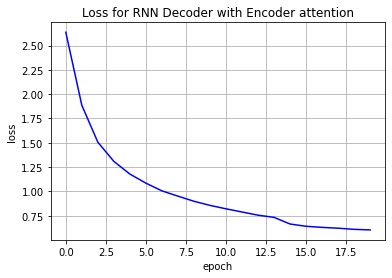

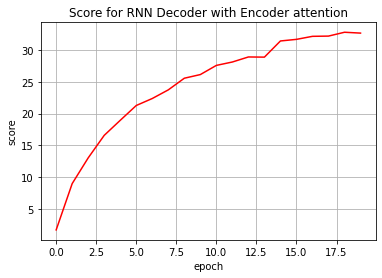

In [28]:
plt.plot(loss_arch_2, color='b')
plt.title('Loss for RNN Decoder with Encoder attention')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.plot(score_arch_2,color='r')
plt.title('Score for RNN Decoder with Encoder attention')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid()
plt.show()

#### RNN Decoder with Encoder & Self attention

In [22]:
loss_arch_3, score_arch_3 = train_model(dataloader_dict, 
                                        arch_3, 
                                        num_epochs=num_epochs, 
                                        saved_model_path=saved_models_dir, 
                                        enc_type='decoder_self_att')

Epoch: [0/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 0 loss = 2.621925852569517, time = 333.54043984413147
validation bleu:  2.309237216323198
Epoch: [1/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 1 loss = 1.841328201994011, time = 324.52758264541626
validation bleu:  8.030260713407374
Epoch: [2/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 2 loss = 1.4920442393942224, time = 326.37212467193604
validation bleu:  13.405830984822678
Epoch: [3/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 3 loss = 1.2892855118516409, time = 325.6084771156311
validation bleu:  16.4131541005567
Epoch: [4/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 4 loss = 1.1462961781718395, time = 324.23166966438293
validation bleu:  19.307882599911263
Epoch: [5/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 5 loss = 1.0415862243261365, time = 325.1707582473755
validation bleu:  21.738410956121545
Epoch: [6/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 6 loss = 0.9530724598760419, time = 324.7231619358063
validation bleu:  22.501428944544216
Epoch: [7/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 7 loss = 0.8877707255183825, time = 322.99433398246765
validation bleu:  24.885055335332027
Epoch: [8/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 8 loss = 0.8266112519268184, time = 320.90570616722107
validation bleu:  26.158962140775326
Epoch: [9/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 9 loss = 0.7782966840465313, time = 321.84266996383667
validation bleu:  27.339549428650933
Epoch: [10/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 10 loss = 0.7350475191409568, time = 321.8488826751709
validation bleu:  27.719849968714872
Epoch: [11/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 11 loss = 0.6945180802133936, time = 322.49152278900146
validation bleu:  28.823596585092254
Epoch: [12/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 12 loss = 0.6579670164558696, time = 321.0626263618469
validation bleu:  29.387279753959533
Epoch: [13/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 13 loss = 0.6294829308161115, time = 320.9829521179199
validation bleu:  30.080196418215724
Epoch: [14/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 14 loss = 0.5986832697635872, time = 320.9561688899994
validation bleu:  30.139201748476555
Epoch: [15/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 15 loss = 0.5704134238063464, time = 319.1912820339203
validation bleu:  31.011735462592288
Epoch: [16/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 16 loss = 0.5469909811779403, time = 318.95460295677185
validation bleu:  31.21871169095903
Epoch: [17/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 17 loss = 0.5253838597737521, time = 319.84224915504456
validation bleu:  31.323903272525012
Epoch: [18/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 18 loss = 0.5014064808301318, time = 320.47532320022583
validation bleu:  31.419357714219654
Epoch: [19/20]


  0%|          | 0/1805 [00:00<?, ?it/s]

epoch 19 loss = 0.4848808593862275, time = 319.2259998321533
validation bleu:  31.48336883121279
Training completed. Best BLEU is 31.48336883121279


In [23]:
torch.save({
    'loss_cache': loss_arch_3,
    'bleu_cache': score_arch_3,
    'model': arch_3
    }, 'arch_3')

In [29]:
loss_arch_3 = torch.load('arch_3', map_location=global_variables.device)['loss_cache']
score_arch_3 = torch.load('arch_3',map_location=global_variables.device)['bleu_cache']

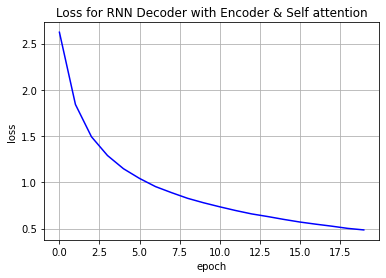

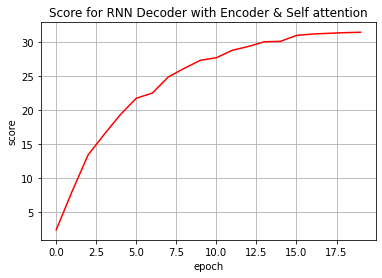

In [30]:
plt.plot(loss_arch_3, color='b')
plt.title('Loss for RNN Decoder with Encoder & Self attention')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

plt.plot(score_arch_3,color='r')
plt.title('Score for RNN Decoder with Encoder & Self attention')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid()
plt.show()

#### Summary Plots for Three Architectures 

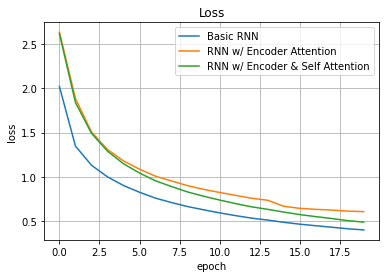

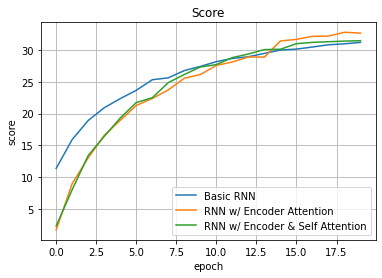

In [31]:
plt.plot(loss_arch_1, label='Basic RNN')
plt.plot(loss_arch_2, label='RNN w/ Encoder Attention')
plt.plot(loss_arch_3, label='RNN w/ Encoder & Self Attention')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(score_arch_1, label='Basic RNN')
plt.plot(score_arch_2, label='RNN w/ Encoder Attention')
plt.plot(score_arch_3, label='RNN w/ Encoder & Self Attention')
plt.title('Score')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.grid()
plt.show()

---
### 2 Attention visualization 

In [ ]:
# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [23]:
from googletrans import Translator
translator = Translator()

In [24]:
import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):
    
#     source_len = np.sort(np.array(val_dataset.main_df['source_len']))
#     len_threshold = [0]+[source_len[x*1000+376] for x in range(1, 21)];
#     len_threshold = np.unique(len_threshold)
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));
    
    for i in notebook.tqdm(range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
#         min_len = 0
        max_len = len_threshold[i]
        
        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)
        
        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);
        
    
    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]
    
    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')
    
    return len_threshold, bin_bl_score
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    print('GT on sentence (src->tgt): ', translator.translate(sentence, 
                                                     src = source_name,
                                                     dest = target_name).text)
    print('GT on prediction (tgt->src): ', translator.translate(prediction, 
                                                     src = target_name,
                                                     dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [25]:
arch_1 = torch.load('arch_1', map_location=global_variables.device)['model']
arch_2 = torch.load('arch_2', map_location=global_variables.device)['model']
arch_3 = torch.load('arch_3', map_location=global_variables.device)['model']

In [26]:
! head -10 'data/valid.en'

you seem happy .
what right do you have to order us around ?
business expenses are tax deductible .
i can t do two things at once .
unfortunately i have to disappoint you .
is this correct ?
i don t blame them for this .
do you have a cellphone ?
promise me you ll be careful .
she knows better than to argue with him .


### 3.2 (a) Basic RNN decoder (no attention)

In [27]:
get_translation(arch_1, 'unfortunately i have to disappoint you .', source_lang_obj, use_cuda)

souce:  unfortunately i have to disappoint you .
prediction:  malheureusement toi je dois te rendre .
GT on sentence (src->tgt):  malheureusement je dois vous décevoir.
GT on prediction (tgt->src):  unfortunately you I have to give you back.


In [28]:
get_translation(arch_1, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle va de lui dire que lui .
GT on sentence (src->tgt):  elle sait qu'il ne faut pas discuter avec lui.
GT on prediction (tgt->src):  she goes to tell him that he .


In [29]:
get_translation(arch_1, 'what right do you have to order us around ?', source_lang_obj, use_cuda)

souce:  what right do you have to order us around ?
prediction:  quel fallait as tu faire pour faire du bon ?
GT on sentence (src->tgt):  De quel droit nous commandez-vous ?
GT on prediction (tgt->src):  what did you have to do to do good?


### 3.2 (b) RNN Decoder with Encoder attention

souce:  unfortunately i have to disappoint you .
prediction:  malheureusement je dois te donner !
GT on sentence (src->tgt):  malheureusement je dois vous décevoir.
GT on prediction (tgt->src):  unfortunately I have to give you!


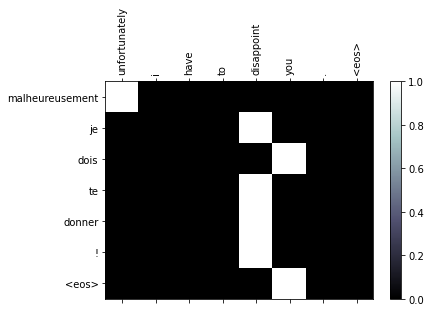

In [30]:
get_translation(arch_2, 'unfortunately i have to disappoint you .', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle sait mieux de se rendre avec lui .
GT on sentence (src->tgt):  elle sait qu'il ne faut pas discuter avec lui.
GT on prediction (tgt->src):  she knows best to go with him.


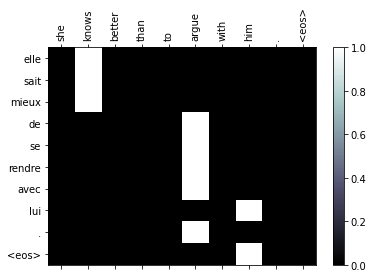

In [31]:
get_translation(arch_2, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  what right do you have to order us around ?
prediction:  qu avez vous pas a faire pour nous faire ?
GT on sentence (src->tgt):  De quel droit nous commandez-vous ?
GT on prediction (tgt->src):  what don't you have to do for us?


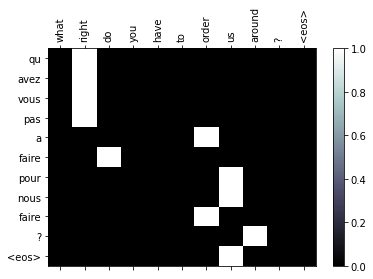

In [32]:
get_translation(arch_2, 'what right do you have to order us around ?', source_lang_obj, use_cuda)

### 3.2 (c)  RNN Decoder with Encoder & Self attention

souce:  unfortunately i have to disappoint you .
prediction:  malheureusement je te dois avoir plus !
GT on sentence (src->tgt):  malheureusement je dois vous décevoir.
GT on prediction (tgt->src):  unfortunately I owe you more!


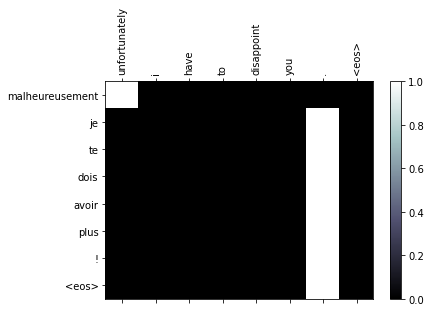

In [33]:
get_translation(arch_3, 'unfortunately i have to disappoint you .', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle est mieux de lui que lui ne peut pas lui faire .
GT on sentence (src->tgt):  elle sait qu'il ne faut pas discuter avec lui.
GT on prediction (tgt->src):  She's better of him than he can't make her.


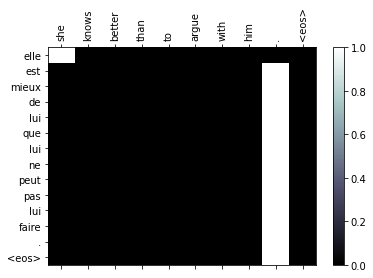

In [34]:
get_translation(arch_3, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  what right do you have to order us around ?
prediction:  que vous avez bien droit pour nous faire ?
GT on sentence (src->tgt):  De quel droit nous commandez-vous ?
GT on prediction (tgt->src):  What are you entitled to do to us?


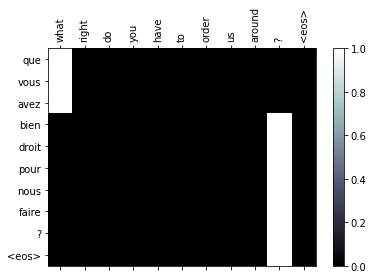

In [35]:
get_translation(arch_3, 'what right do you have to order us around ?', source_lang_obj, use_cuda)

In [45]:
# The End